**CV2022 - Week 4**

**Contents**

* [k-NN eigenfilter](https://colab.research.google.com/drive/1JGlEDPi7nhzftAwXiGyZxbHAV_SGkmFY#scrollTo=xZrTH81AKLJe)

* [Harris corner detector](https://colab.research.google.com/drive/1JGlEDPi7nhzftAwXiGyZxbHAV_SGkmFY#scrollTo=mYalZtoiYaYB)

* [Matching tests](https://colab.research.google.com/drive/1JGlEDPi7nhzftAwXiGyZxbHAV_SGkmFY#scrollTo=Qt6CyxsbSRkM)

* [PCA](https://colab.research.google.com/drive/1JGlEDPi7nhzftAwXiGyZxbHAV_SGkmFY#scrollTo=9t5QYvJAaufh)


**Homework**

* **1bp** Replace the implemented solution for corner detection with the more stable *OpenCV* provided method. Assess the quality of the features matching using the presented methods.

* **2bp** Use a PCA compressed version of the local patch as feature descriptor. Assess the quality of the matches when increasing the number of principal components used for the feature descriptor.

* **1bp** Use the *scikit* pipelining method to chain different feature descriptors extractors and classifiers.

* **2bp** Simulate image compression using different combinations of the principal components. Identify the type of information coded by each component. Implement a linear blending feature to suppress/enhance each component. 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common
  libcairo-script-interpreter2 libcairo2-dev libcupsfilters1 libcupsimage2
  libdjvulibre-dev libdjvulibre-text libdjvulibre21 libgdk-pixbuf2.0-dev
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 liblcms2-dev liblqr-1-0
  liblqr-1-0-dev libmagickcore-6-arch-config libmagickcore-6-headers
  libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra libmagickcore-6.q16-dev
  libmagickwand-6-headers libmagickwand-6.q16-3 libmagickwand-6.q16-dev
  libpixman-1-dev librsvg2-dev libwmf-dev libwmf0.2-7 libxcb-shm0-dev
  poppler-data
Suggested packages:
  fonts-noto ghostscript-x libcairo2-doc inkscape libjxr-tools librsvg2-doc
  libwmf-doc libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts

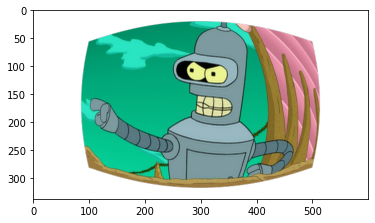

In [1]:
# install the Wand package
!apt-get install libmagickwand-dev
!pip install Wand

import matplotlib.pyplot as plt
import numpy as np
from wand.image import Image


path = '/content/drive/MyDrive/CV2022/pics/bender.png'

with Image(filename=path) as img:
    img.virtual_pixel = 'transparent'
    img.distort('barrel', (0.2, 0.0, 0.0, 1.0))
    # convert to opencv/numpy array format
    img_opencv = np.array(img)
    #img.save(filename='img_barrel.png')

#display result with opencv
#distorsioned_img = cv.imread('img_barrel.png')
plt.imshow(img_opencv)

**1. k-NN eigenfilter**

This was the third exercise of the *week 3* homework. It was stated that the proposed solution should be similar to the eigenfilter definition implemnted last week. The difference would be the data used for the covariance matrix computation, as in this solution the covariance matrix would be computed using the k-Nearest Neighbors approach. The solution is provided as follows.

In [2]:
from numpy.linalg import eig 
from sklearn.neighbors import NearestNeighbors


def top_eigenvalues(in_data):
  # here the in_data should be a k x 1 array
  eps = np.finfo(np.float32).eps

  norm_data = (in_data - in_data.min())/(in_data.max() - in_data.min() + eps)
  covar_matrix = norm_data @ norm_data.T
  eigen_vals, eigen_vect = eig(np.nan_to_num(covar_matrix))
  eigen_vals = (np.sort(np.abs(eigen_vals))[::-1])
  return eigen_vals[0:3]


def eigen_filter(input_image, k, agg_function):
  input_data = np.expand_dims(input_image.flatten(), axis=1)

  knn_model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
  knn_model.fit(input_data)

  h, w = input_image.shape
  output_img = np.zeros((h, w, 3))

  for i in range(h):
    for j in range(w):
      dist, neigh = knn_model.kneighbors(np.array([[input_image[i, j]]]))
      neigh_values = np.zeros((k, 1))
      for kth, neigh_idx in enumerate(neigh[0]):
          neigh_values[kth, 0] = input_data[neigh_idx]
      output_img[i, j, :] = agg_function(neigh_values)

  output_img = (output_img  - output_img.min())/(output_img.max() - output_img.min())
  output_img = np.array(np.clip(255 * output_img, a_min=0, a_max=255), dtype=np.uint8)
  return output_img


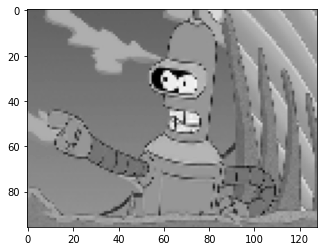

In [3]:
import cv2 as cv


img_bender = cv.imread(path)
dim=(128, 96)
bender_img_gray = cv.resize(cv.cvtColor(img_bender, cv.COLOR_BGR2GRAY), dim, interpolation=cv.INTER_NEAREST)
plt.imshow(bender_img_gray, cmap="gray")

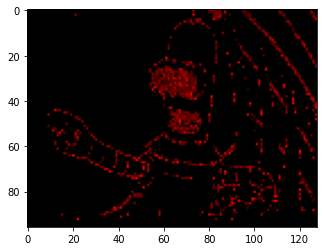

In [7]:
# as we need more than 3 eigenvalues, make sure k > 3
plt.imshow(eigen_filter(bender_img_gray, 25, top_eigenvalues))

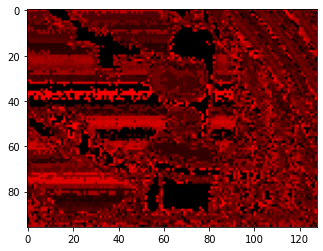

In [4]:
# as we need more than 3 eigenvalues, make sure k > 3
plt.imshow(eigen_filter(bender_img_gray, 255, top_eigenvalues))

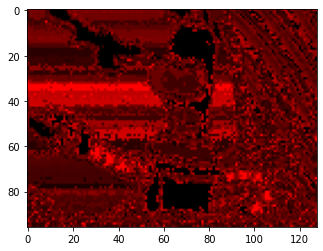

In [5]:
# as we need more than 3 eigenvalues, make sure k > 3
plt.imshow(eigen_filter(bender_img_gray, 319, top_eigenvalues))

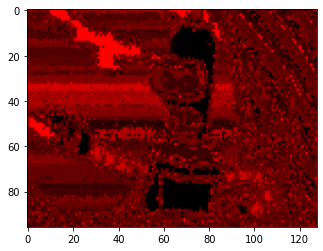

In [6]:
# as we need more than 3 eigenvalues, make sure k > 3
plt.imshow(eigen_filter(bender_img_gray, 383, top_eigenvalues))

**2. Harris corner detection**

In this exercise, we will implment a Harris corner detector for feature extraction. Additional feature extraction and metching methods will be featured in the next sections.

The Harris corner detector starts with the image gradients, that will be computed using the next correlation masks:

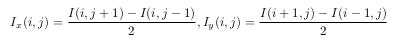

Next, the local auto-correlation matrix is going to be defined, for each pixel *p*, where *N(p)* is the neighborhood of the pixel *p*. The weights are  defined using the normal distribution cenetered in *p*, with *sigma* variance. Values for these hyperparameters are going to be provided in the implementation.

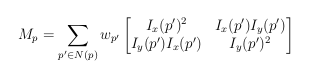

Then, the Harris response ig going to be computed using the next equation:


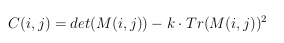

Finally, an additional step of non-maximum values suppression is going to be added, to get the filter response around the corners, and their position. For a pixel to be corresponding to a corner, it has to be a local patch maximum harris response and it the response has to be above a given threshold. 
Recommended parameters are provided with the implementation.


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
from scipy.ndimage.filters import maximum_filter


def extract_harris_response(in_img, sigma, k, thresh, min_distance):
  h, w = in_img.shape
  width = int(np.ceil(3 * sigma)) # 97% of the values are in [m-3s, m+3s]
  xx = np.vstack([np.arange(-width, width + 1, dtype=np.float32) for _ in range(2 * width + 1)])
  yy = xx.T
  gaussian_kern = 1/(2 * sigma**2) * (-(np.square(xx) + np.square(yy)))
  gaussian_kern = np.exp(gaussian_kern)
  
  # compute image gradients
  horizontal_filter = 1/2 * np.array([[0, 0, 0],
                                      [-1, 0, 1],
                                      [0, 0, 0]])
  vertical_filter = 1/2 * np.array([[0, -1, 0],
                                    [0, 0, 0],
                                    [0, 1, 0]])
  in_img_x = cv.filter2D(in_img, -1, horizontal_filter)
  in_img_y = cv.filter2D(in_img, -1, vertical_filter)


  img_x_sq = cv.filter2D(np.square(in_img_x), -1, gaussian_kern)
  img_y_sq = cv.filter2D(np.square(in_img_y), -1, gaussian_kern)
  img_xy = cv.filter2D(in_img_x * in_img_y, -1, gaussian_kern)
  # plt.imshow(img_xy)

  C = np.zeros((h, w))
  # keep indices for the corners
  corners = np.zeros((2, h * w))

  # compute the filter response for each of the image pixels
  for i in range(h):
    for j in range(w):
      H = np.array([[img_x_sq[i, j], img_xy[i, j]], 
                    [img_xy[i, j], img_y_sq[i, j]]])
      filter_response = np.linalg.det(H) - k * (np.trace(H) ** 2)
      C[i, j] = filter_response

  # perform non_max suppression
  coordinates = peak_local_max(C, min_distance=min_distance)


  corner_idx = 0
  for i, j in coordinates:
    if C[i, j] > thresh * C.max():
        corners[:, corner_idx] = np.array([i, j])
        corner_idx += 1
  
  return C, corners[:, :corner_idx]



In [ ]:
# recommended params for sigma [.5, 1, 2]
# k [4e-2, 6e-2]
# thresh [1e-6, 1e-4]
img_house = cv.imread('/content/drive/MyDrive/CV2022/pics/image001.jpg')
in_img = cv.cvtColor(img_house, cv.COLOR_BGR2GRAY).astype(np.float32)
C, corner_idx = extract_harris_response(in_img, 1, 4e-2, 1e-4, min_distance=45)


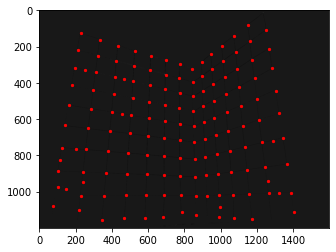

In [ ]:
plt.imshow(C, cmap='gray')
for position in corner_idx.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

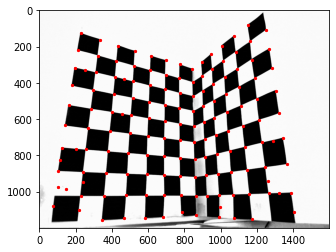

In [ ]:
plt.imshow(in_img, cmap='gray')
for position in corner_idx.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

**3. Feature extraction and matching tests**

In this section we are going to experiment with several local features extracted around the detected corners, and we are going to implement several feature matching techniques such that we can match similar textures from different images representing the same object. 

We are going to explore the *nearest neighbor* approach and it's limitations, and then, we are going to further add criterias for a stronger match. Correct matches are fundamental for applications such as *stereo vision* and *3D reconstruction*. 

In [ ]:
img_l1 = cv.imread('/content/drive/MyDrive/CV2022/pics/I1.jpg')
img_l2 = cv.imread('/content/drive/MyDrive/CV2022/pics/I2.jpg')

h, w, _ = img_l1.shape
print(h, w)

l1_gray = cv.cvtColor(img_l1, cv.COLOR_BGR2GRAY).astype(np.float32)
l2_gray = cv.cvtColor(img_l2, cv.COLOR_BGR2GRAY).astype(np.float32)

C_l1, l1_corner_idx = extract_harris_response(l1_gray, 1, 4e-2, 1e-4, min_distance=30)
C_l2, l2_corner_idx = extract_harris_response(l2_gray, 1, 4e-2, 1e-4, min_distance=30)

490 653


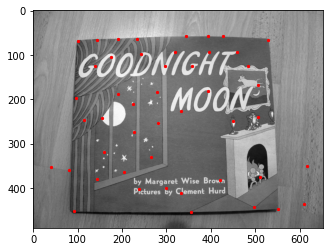

In [ ]:
plt.imshow(l1_gray, cmap='gray')
for position in l1_corner_idx.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

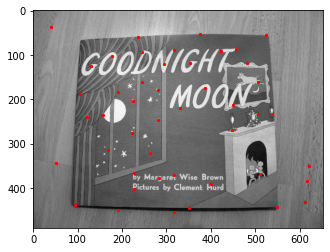

In [ ]:
plt.imshow(l2_gray, cmap='gray')
for position in l2_corner_idx.T:
  plt.scatter(position[1], position[0], s=5, c='red', marker='o')

The next step would be to define a feature extractor around the given points. The feature will be simply the intensity values in the 9x9 local patch, centered in the corner pixel. If the value is not outside of the 4 pixels border, this candidate point is going to be discarded.

In [ ]:
def filter_candidate_points(candidate, width, height):
  y, x = candidate # keep in mind the 
  if x >= 4 and x < width - 4 and y >=4 and y < height - 4:
    return True
  else:
    return False

In [ ]:
filtered_l1_candidates = np.array([x for x in l1_corner_idx.T if filter_candidate_points(x, w, h)]).T
filtered_l2_candidates = np.array([x for x in l2_corner_idx.T if filter_candidate_points(x, w, h)]).T

In [ ]:
def feature_extractor(img, point):
  i, j = point.astype(np.int32)
  return img[(i-4):(i+5), (j-4):(j+5)].flatten()

Next, we qare going to define a data matrix for each of the compared sets and we are going to fit a nearest neighbor model. 


In [ ]:
l1_data = np.array([feature_extractor(l1_gray, x) for x in filtered_l1_candidates.T])
l2_data = np.array([feature_extractor(l2_gray, x) for x in filtered_l2_candidates.T])
print(l1_data.shape, l2_data.shape)

(47, 81) (46, 81)


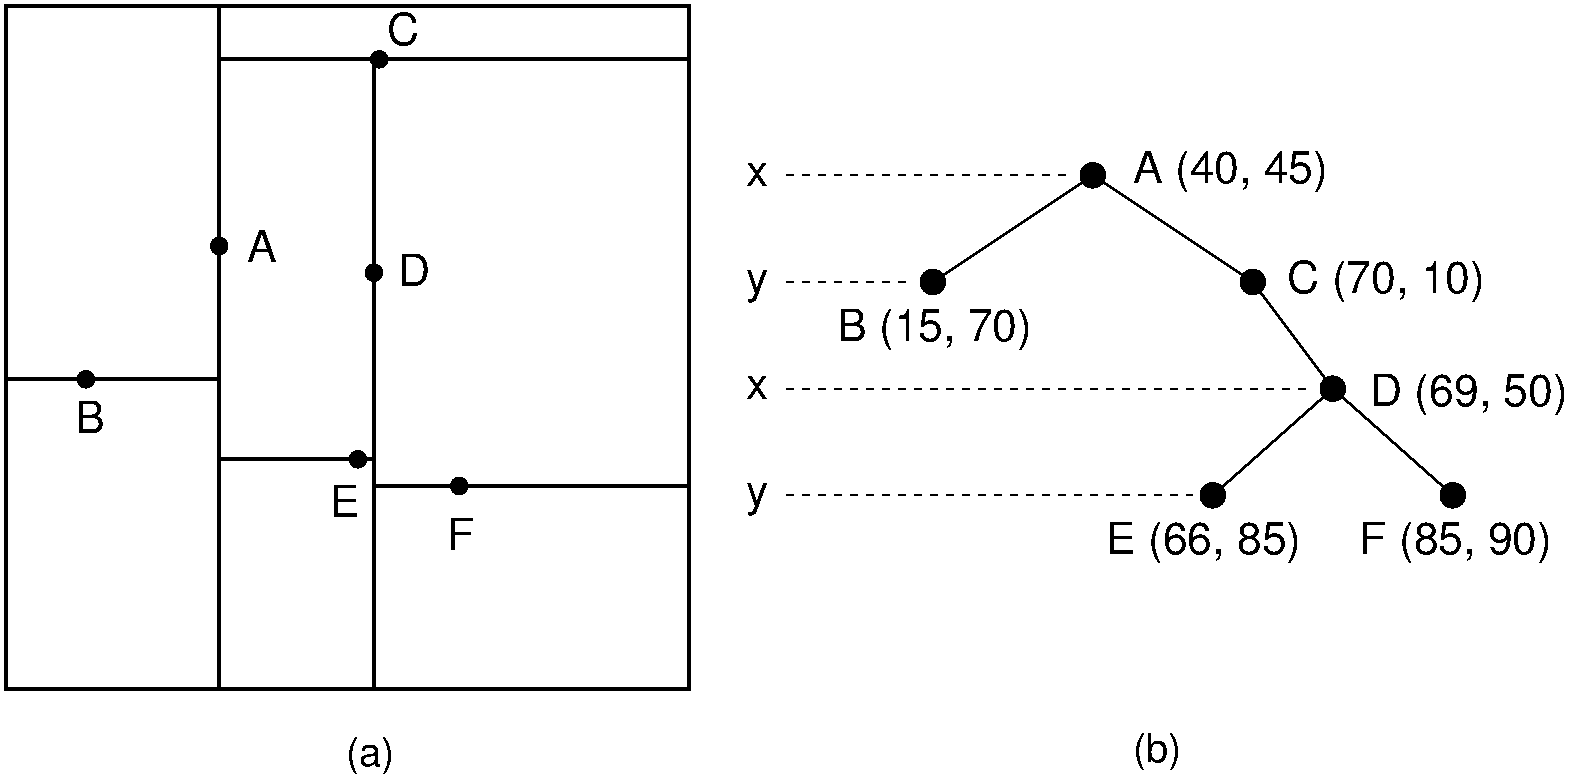



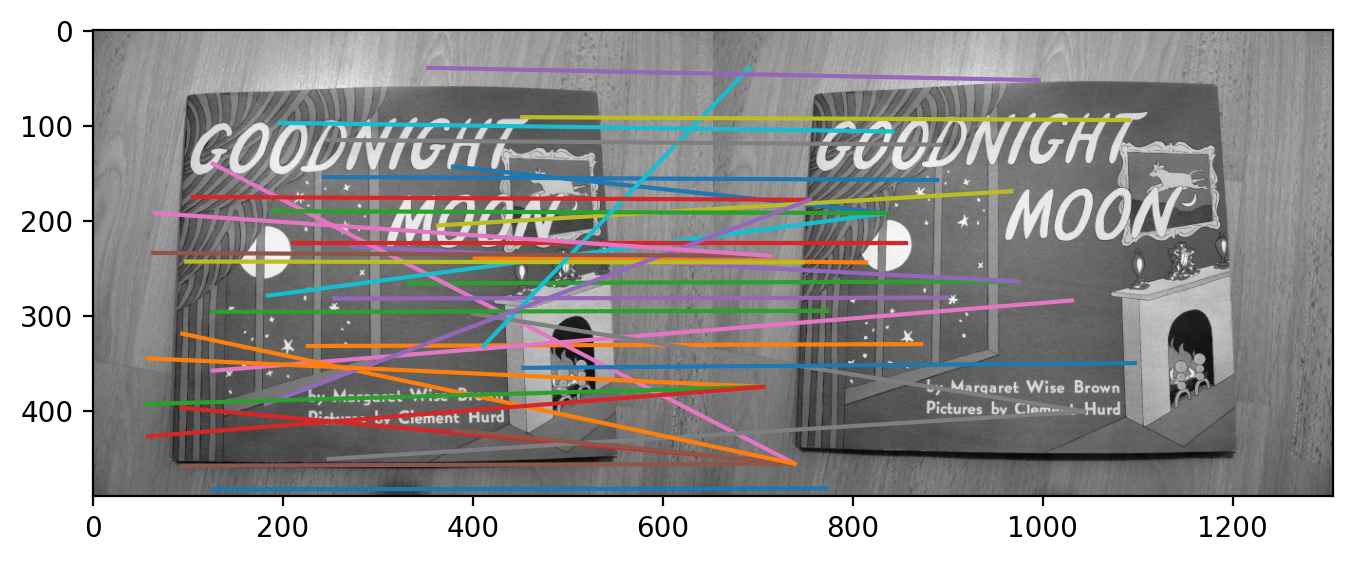

In [ ]:
from sklearn.neighbors import KDTree


def plot_matches(img1, img2, matches):
  plt.rcParams['figure.figsize'] = [8, 4]
  plt.rcParams['figure.dpi'] = 200
  h, w = img1.shape
  result = np.zeros((h, 2 * w))
  result[:, :w] = img1
  result[:, w:] = img2
  plt.imshow(result, cmap='gray')
  for y1, x1, y2, x2 in matches.T:
    xs = [x1, x2 + w]
    ys = [y1, y2]
    if filter_candidate_points([y1, x1], w, h) == True \
     and filter_candidate_points([y2, x2 + w],  2* w, h) == True:
      plt.plot(xs, ys)


l1_kdt = KDTree(l1_data, leaf_size=5, metric='euclidean')
l2_kdt = KDTree(l2_data, leaf_size=5, metric='euclidean')

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, the nearest neighbor in the other set is 
# considered the match
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx[0][0] #query interface limitation. Print the fn output to understand

  lines_nneigh[0, i] = filtered_l1_candidates.T[i, 1]
  lines_nneigh[1, i] = filtered_l1_candidates.T[i, 0]

  lines_nneigh[2, i] = filtered_l2_candidates.T[j, 1]
  lines_nneigh[3, i] = filtered_l2_candidates.T[j, 0]

plot_matches(l1_gray, l2_gray, lines_nneigh)

**Mutual Nearest Neighbor**

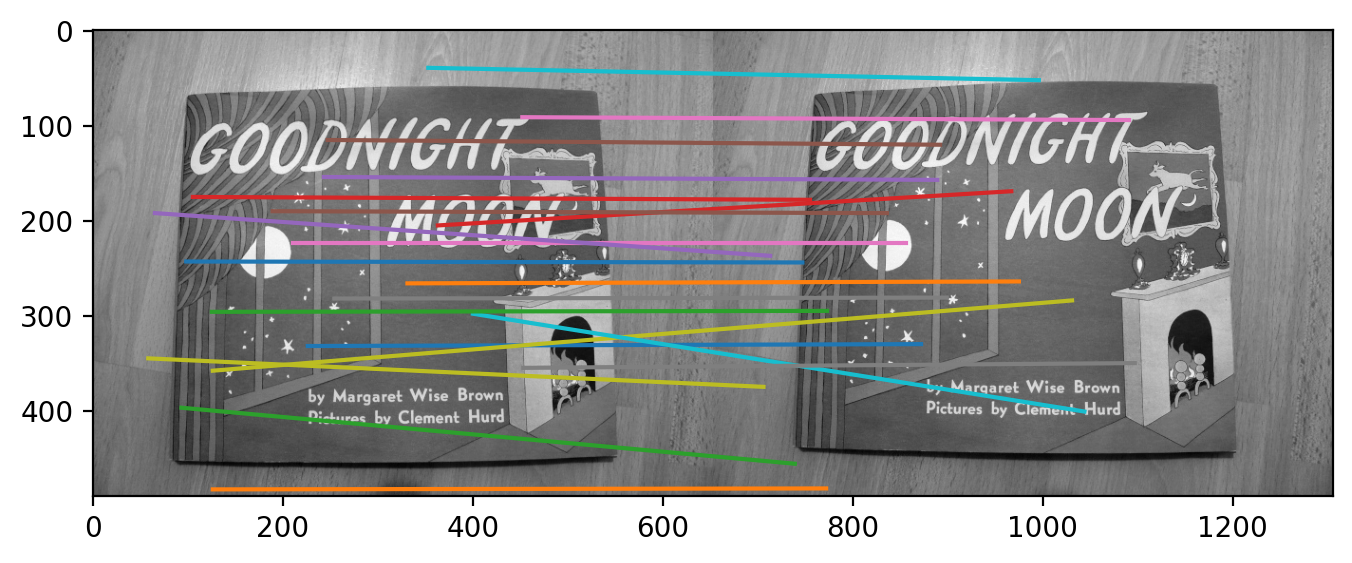

In [ ]:
lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, two points x_i1, x_j2 are considered a match between 
# sets 1 and 2 if x_i1 is the nearest neighbor of x_j2 and x_j2 is the 
# nearest neighbor of x_i1
match_idx = 1
for i in range(l1_data.shape[0]):
  dist_1, idx_1 = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=1)
  j = idx_1[0][0]
  dist_2, idx_2 = l1_kdt.query(np.expand_dims(l2_data[j, :], axis=0), k=1)
  same_i = idx_2[0][0]
  if i == same_i:
    lines_nneigh[0, match_idx] = filtered_l1_candidates.T[i, 1]
    lines_nneigh[1, match_idx] = filtered_l1_candidates.T[i, 0]

    lines_nneigh[2, match_idx] = filtered_l2_candidates.T[j, 1]
    lines_nneigh[3, match_idx] = filtered_l2_candidates.T[j, 0]
    match_idx += 1

lines_nneigh = lines_nneigh[:, :match_idx]
plot_matches(l1_gray, l2_gray, lines_nneigh)

**Ratio Tests**

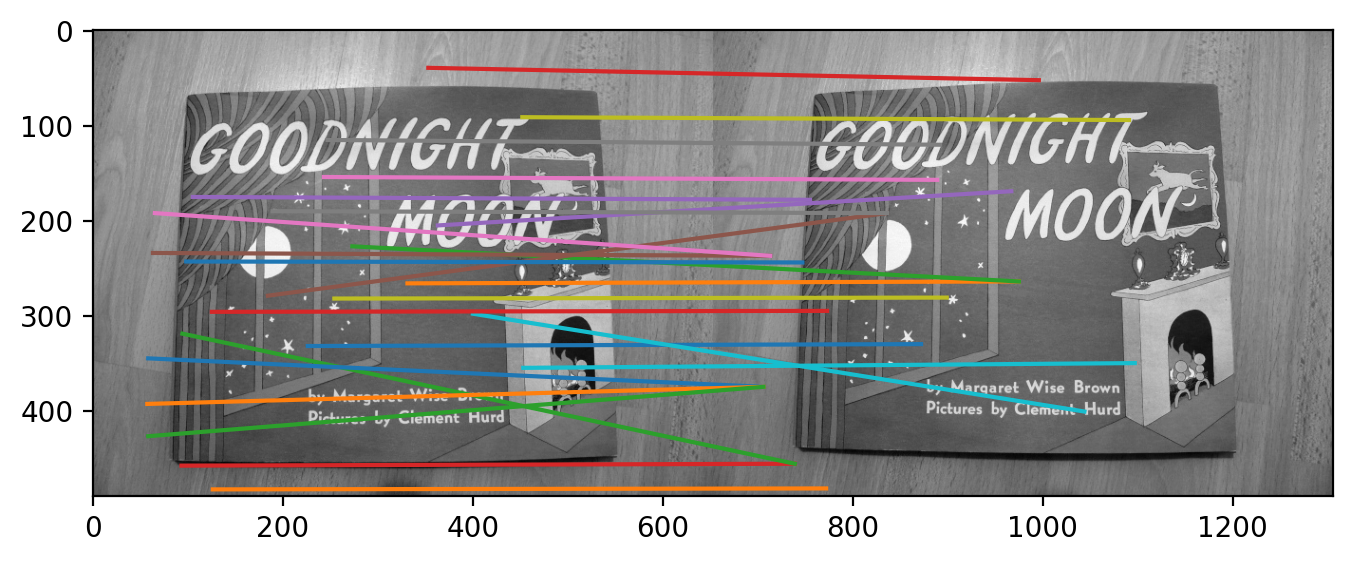

In [ ]:
r = 0.2

lines_nneigh = np.zeros((4, l1_data.shape[0]))
# for this matching, two points x_i1, x_j2 are considered a match between 
# sets 1 and 2 if x_i1 is the nearest neighbor of x_j2 and the second nearest
# neighbor is at a distance greater by a given ratio in [0, 1)
match_idx = 1
for i in range(l1_data.shape[0]):
  dist, idx = l2_kdt.query(np.expand_dims(l1_data[i, :], axis=0), k=2)
  j = idx[0][0]
  if dist[0, 1]/dist[0, 0] > (1 + r):
    lines_nneigh[0, match_idx] = filtered_l1_candidates.T[i, 1]
    lines_nneigh[1, match_idx] = filtered_l1_candidates.T[i, 0]

    lines_nneigh[2, match_idx] = filtered_l2_candidates.T[j, 1]
    lines_nneigh[3, match_idx] = filtered_l2_candidates.T[j, 0]
    match_idx += 1

lines_nneigh = lines_nneigh[:, :match_idx]
plot_matches(l1_gray, l2_gray, lines_nneigh)

**PCA**

(256, 256, 3)
(768, 256)
(768, 10)
0.9623755400685703


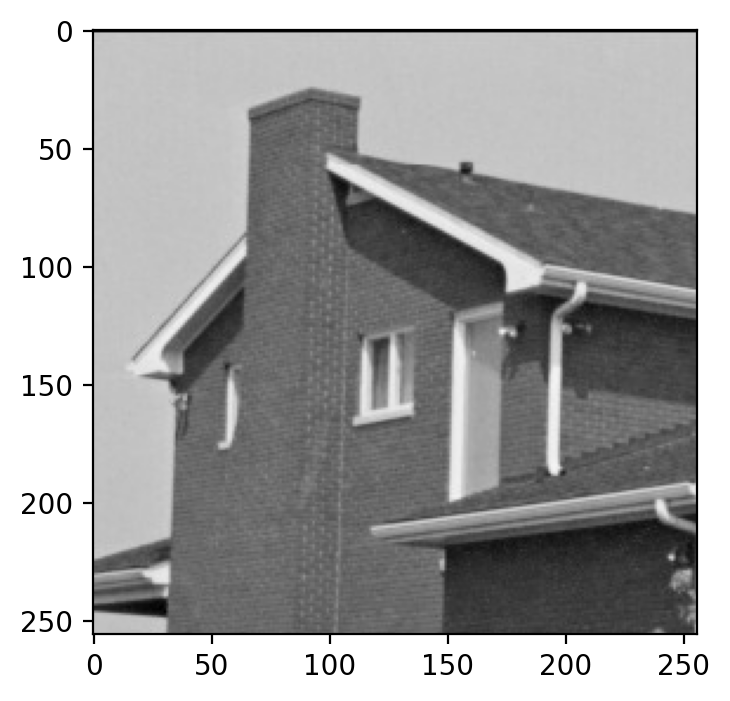

In [ ]:
from sklearn.decomposition import PCA

img_house = cv.imread("/content/drive/MyDrive/CV2022/pics/house.jpg")
plt.imshow(img_house)
print(img_house.shape)
img_house = np.reshape(img_house, (-1, 256))
print(img_house.shape)
pca = PCA(10).fit(img_house)
img_transformed = pca.transform(img_house)
print(img_transformed.shape)
print(np.sum(pca.explained_variance_ratio_))


(768, 256)
(256, 256, 3)


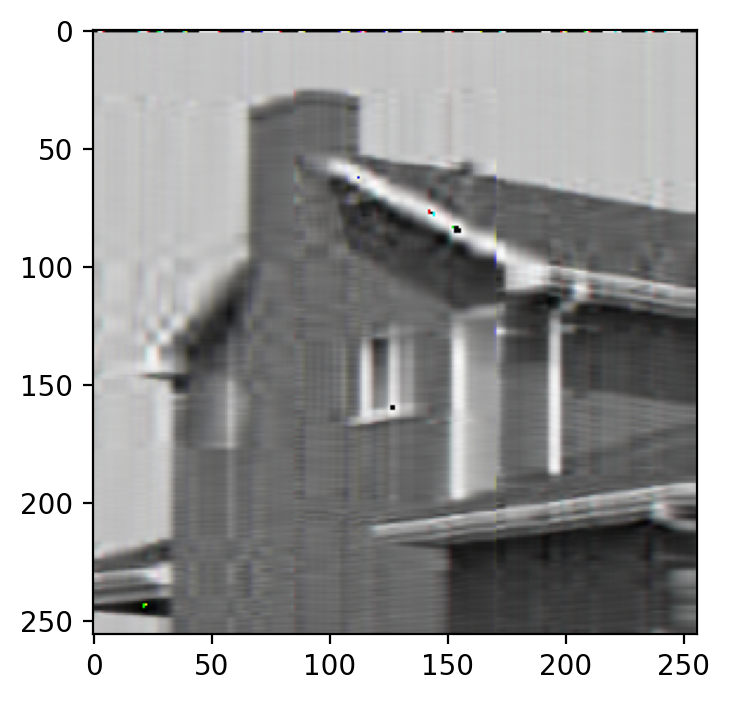

In [ ]:
temp = pca.inverse_transform(img_transformed) 
print(temp.shape)
temp = np.reshape(temp, (256, 256, 3))
temp =  temp.astype(np.uint8)
print(temp.shape) 
plt.imshow(temp)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 4096)
(300, 4096) (100, 4096)


PCA(n_components=150, whiten=True)

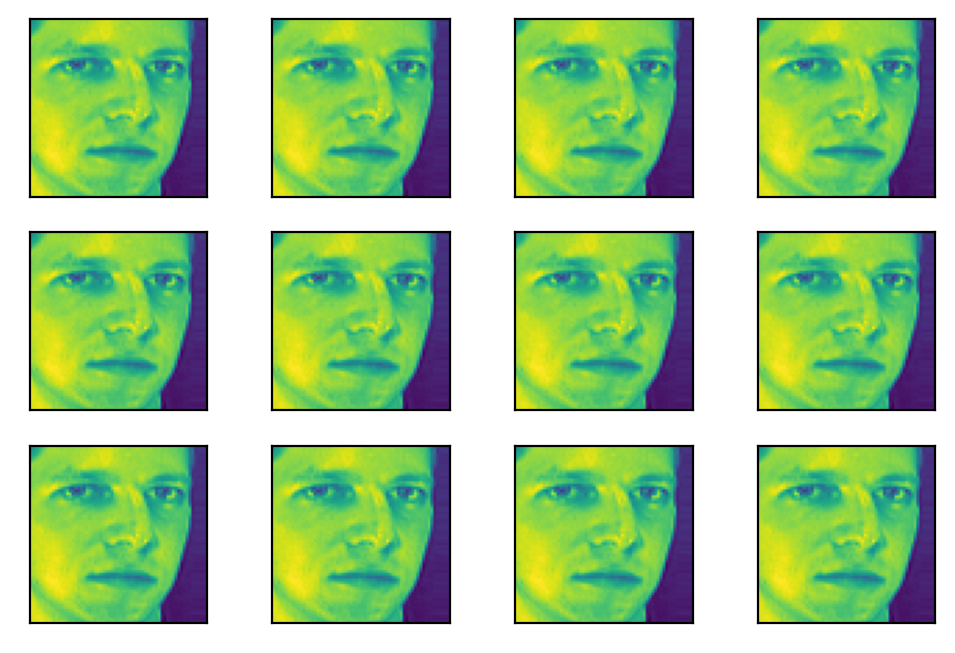

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import decomposition
from sklearn.model_selection import train_test_split


faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)

fig = plt.figure(figsize=(6, 4))
for i in range(12):
  ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
  ax.imshow(faces.images[1])

# do a dataset split to evaluate performance
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)


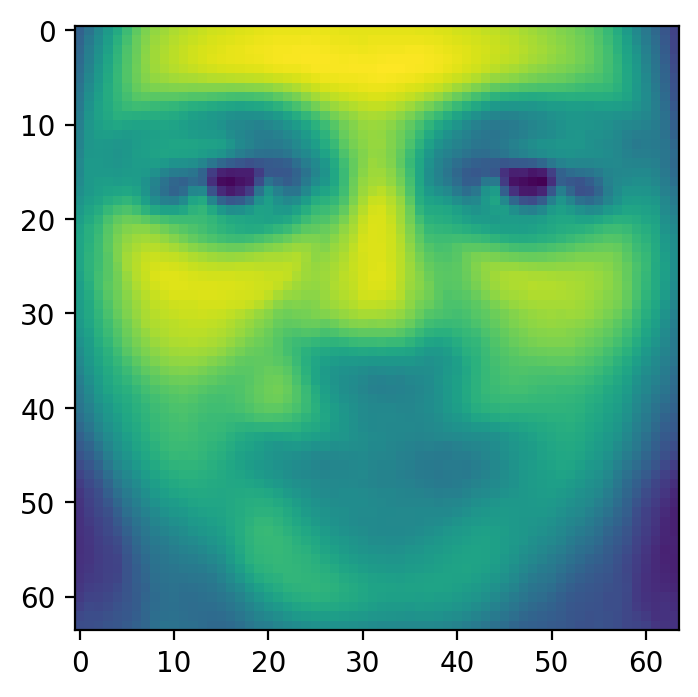

In [ ]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape))

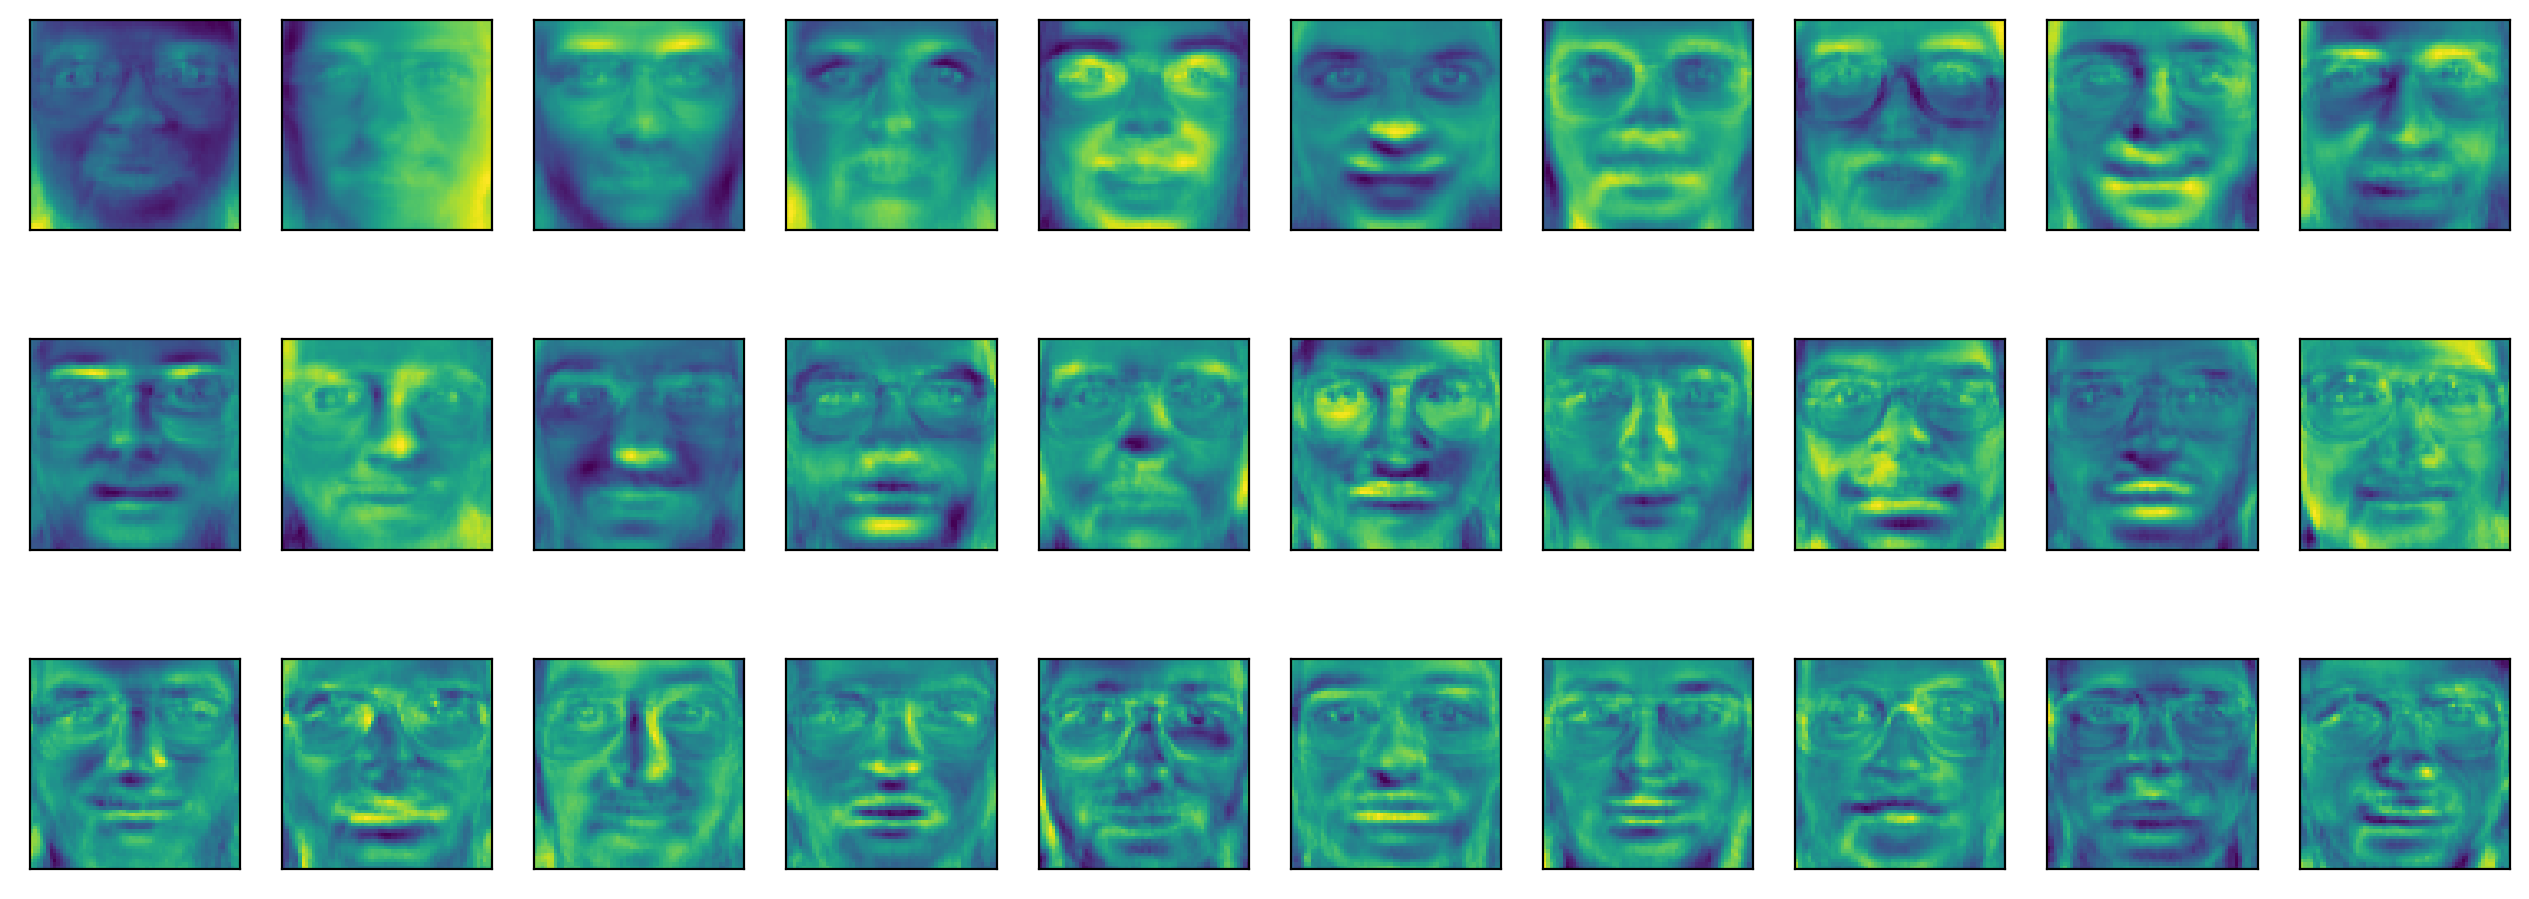

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape))

**References**

[About Principal Component Analysis](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html)

[About the Harris corner detector](https://docs.opencv.org/3.4/d4/d7d/tutorial_harris_detector.html)

[About Nearest Neighbor Agorithm](https://scikit-learn.org/stable/modules/neighbors.html)

[KDTrees as data structures](https://opendsa-server.cs.vt.edu/ODSA/Books/CS3/html/KDtree.html)